### Úvod a príprava dát

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# 1. Načítanie JSON súboru
with open("data.json", "r") as file:
    json_data = json.load(file)

# 2. Extrahovanie sekcie "data"
df = pd.json_normalize(json_data["data"])

# 3. Premenovanie stĺpcov pre lepšiu čitateľnosť
df.columns = df.columns.str.replace(r"\.", "_", regex=True)

# 4. Prevod timestampu na datetime formát
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# 5. Nastavenie časového indexu
df.set_index('timestamp', inplace=True)

# 6. Hodinová agregácia (napr. priemer)
df = df.resample('1h').mean()

# 7. Zobrazenie prvých riadkov z hodinovo agregovaných dát
print(df.tail())

                           U_L1      I_L1         P_L1        Q_L1
timestamp                                                         
2024-11-25 05:00:00  241.875683  1.899683   376.167333 -157.742150
2024-11-25 06:00:00  242.101150  2.517483   538.411867  -83.347750
2024-11-25 07:00:00  242.210167  1.812800   276.782950  110.196817
2024-11-25 08:00:00  241.571183  5.723533  1122.427583  380.538150
2024-11-25 09:00:00  241.406000  2.858000   363.827000  380.706000


In [4]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# 1. Načítanie JSON súboru
with open("data2.json", "r") as file:
    json_data2 = json.load(file)

# 2. Extrahovanie sekcie "data"
df2 = pd.json_normalize(json_data2["data"])

# 3. Premenovanie stĺpcov pre lepšiu čitateľnosť
df2.columns = df2.columns.str.replace(r"\.", "_", regex=True)

# 4. Prevod timestampu na datetime formát
df2['timestamp'] = pd.to_datetime(df2['timestamp'], unit='s')

# 5. Nastavenie časového indexu
df2.set_index('timestamp', inplace=True)

# 6. Hodinová agregácia (napr. priemer)
df2 = df2.resample('1h').mean()

# 7. Zobrazenie prvých riadkov z hodinovo agregovaných dát
print(df2.tail())


                           U_L1        U_L2        U_L3  U_cumulative  \
timestamp                                                               
2024-11-25 05:00:00  243.024067  244.675467  235.729450    241.143050   
2024-11-25 06:00:00  245.241050  245.588800  239.173983    243.334667   
2024-11-25 07:00:00  245.807700  245.210783  241.104100    244.040817   
2024-11-25 08:00:00  243.456817  246.216533  240.537400    243.403633   
2024-11-25 09:00:00  244.010000  243.160000  238.323000    241.831000   

                         I_L1      I_L2      I_L3  I_cumulative       P_L1  \
timestamp                                                                    
2024-11-25 05:00:00  0.447417  0.378317  0.213667      1.039400  53.797383   
2024-11-25 06:00:00  0.422050  0.413767  0.149733      0.985550  42.064467   
2024-11-25 07:00:00  0.421483  0.358733  0.149550      0.929767  42.364467   
2024-11-25 08:00:00  0.418917  0.360300  0.304233      1.083450  41.936767   
2024-11-25 09:00:00 

In [5]:
def clip_extremes_inplace(df, lower_q=0.005, upper_q=0.995):
    for col in df.columns:
        lower = df[col].quantile(lower_q)
        upper = df[col].quantile(upper_q)
        df[col] = df[col].clip(lower=lower, upper=upper)


In [6]:
clip_extremes_inplace(df2)

In [7]:
import pandas as pd

def fill_rows_from_previous_day(df, target_column='P_cumulative'):
    df_filled = df.copy()
    for timestamp in df.index:
        if pd.isna(df_filled.loc[timestamp, target_column]):
            prev_day_timestamp = timestamp - pd.Timedelta(days=1)
            if prev_day_timestamp in df_filled.index:
                df_filled.loc[timestamp] = df_filled.loc[prev_day_timestamp]
    return df_filled

In [9]:
df2 = fill_rows_from_previous_day(df2)

In [14]:
df2.isna().any(axis=1).sum()

0

### Modelovanie pomocou Auto ARIMA – hľadanie ideálnych parametrov

V tomto experimente sme využili funkciu `auto_arima` z knižnice `pmdarima`, ktorá automaticky vyhľadáva optimálnu kombináciu parametrov pre model ARIMA/SARIMA na základe zvolených rozsahov.

#### Postup:

- Dáta boli najprv zoradené podľa časovej osi a spracované ako hodinový časový rad – ako poistka pre zabezpečenie správneho poradia údajov.
- Boli definované časové obdobia **7, 14 a 21 dní**, pričom pre každý variant bola predikcia vykonaná na **nasledujúci 1 deň**.
- Tréning prebiehal na dátach zvoleného obdobia a následne sa model snažil predpovedať hodnoty činného výkonu v nasledujúcom dni.
- Funkcia `auto_arima` vyhľadala najvhodnejšiu kombináciu parametrov na základe optimalizačných kritérií.
- Pre každé nastavenie tréningového intervalu bola vypočítaná metrika **MAPE** (Mean Absolute Percentage Error), ktorá hodnotila presnosť predikcie.
- Výsledky predikcie boli vizualizované v grafoch, kde boli porovnané skutočné hodnoty so simulovanými.
- Najvhodnejšia kombinácia za zvolené obdobie bude následne použitá pri ďalšom modelovaní.



Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=1656.138, Time=0.33 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=1692.218, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=1624.551, Time=1.86 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=3.91 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=1690.245, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=1655.748, Time=0.16 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=6.54 sec
 ARIMA(1,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=1665.750, Time=2.11 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=1625.044, Time=2.28 sec
 ARIMA(1,0,1)(1,1,0)[24] intercept   : AIC=1625.400, Time=2.95 sec
 ARIMA(0,0,1)(1,1,0)[24] intercept   : AIC=1630.121, Time=2.96 sec
 ARIMA(2,0,1)(1,1,0)[24] intercept   : AIC=1623.179, Time=5.49 sec
 ARIMA(2,0,1)(0,1,0)[24] intercept   : AIC=1653.821, Time=0.57 sec
 ARIMA(2,0,1)(1,1,1)[24] intercept

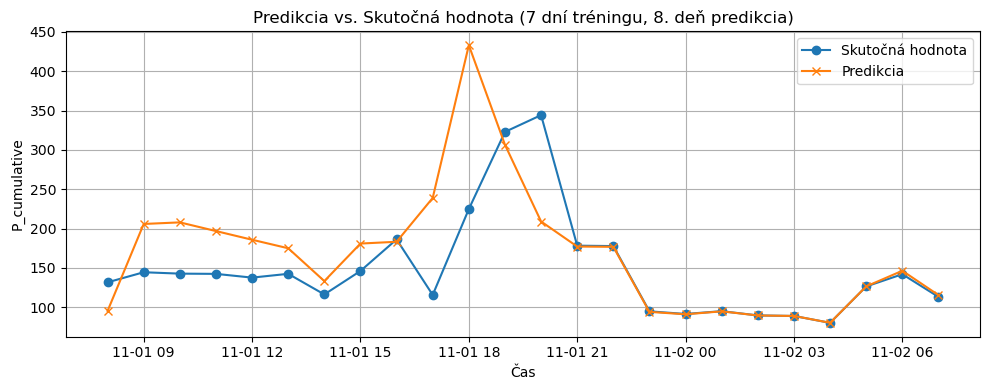

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error

# Zoradenie podľa času, poistka!!!
df2 = df2.sort_index()

# Nastavenie časových okien
train_days = 7
test_days = 1

# Tréning: 1. – 7. deň
start = df2.index[0]
train_end = start + pd.Timedelta(days=train_days)
test_end = train_end + pd.Timedelta(days=test_days)

train = df2.loc[(df2.index >= start) & (df2.index < train_end)]
test = df2.loc[(df2.index >= train_end) & (df2.index < test_end)]

# Tréning modelu pomocou auto_arima
model = auto_arima(train['P_cumulative'],
                   start_p=1, max_p=3,
                   start_q=1, max_q=3,
                   start_P=0, max_P=1,
                   start_Q=0, max_Q=1,
                   d=None, D=1,
                   seasonal=True,
                   m=24,
                   stepwise=True,
                   n_jobs=1,
                   suppress_warnings=True,
                   error_action='ignore',
                   trace=True)

# Výpis nájdených najlepších parametrov
print("\n🔧 Najlepšie nájdené parametre:")
print(f"order = {model.order}")
print(f"seasonal_order = {model.seasonal_order}")

# Predikcia na 1 deň (24 hodín)
forecast = model.predict(n_periods=24)
true_values = test['P_cumulative'].values[:len(forecast)]
forecast = forecast[:len(true_values)]

# Výpočet MAPE
mape = mean_absolute_percentage_error(true_values, forecast)
print(f"\n MAPE: {mape * 100:.2f}%")

# Graf – predikcia vs. skutočnosť
plt.figure(figsize=(10, 4))
plt.plot(test.index, true_values, label='Skutočná hodnota', marker='o')
plt.plot(test.index, forecast, label='Predikcia', marker='x')
plt.title('Predikcia vs. Skutočná hodnota (7 dní tréningu, 8. deň predikcia)')
plt.xlabel('Čas')
plt.ylabel('P_cumulative')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=3522.706, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=3634.020, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=3452.915, Time=4.06 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=3.71 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=3632.034, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=3523.103, Time=0.28 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=6.64 sec
 ARIMA(1,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=5.46 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=3558.983, Time=3.86 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=3452.335, Time=3.60 sec
 ARIMA(2,0,0)(0,1,0)[24] intercept   : AIC=3522.699, Time=0.44 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=9.09 sec
 ARIMA(2,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=6.11 sec
 ARIMA(3,0,0)(1,1,0)[24] intercept   : AIC=3454.152, Time=5.79 sec
 ARIMA(2,0,1)(1,1,0)[24] intercept   : AIC=3

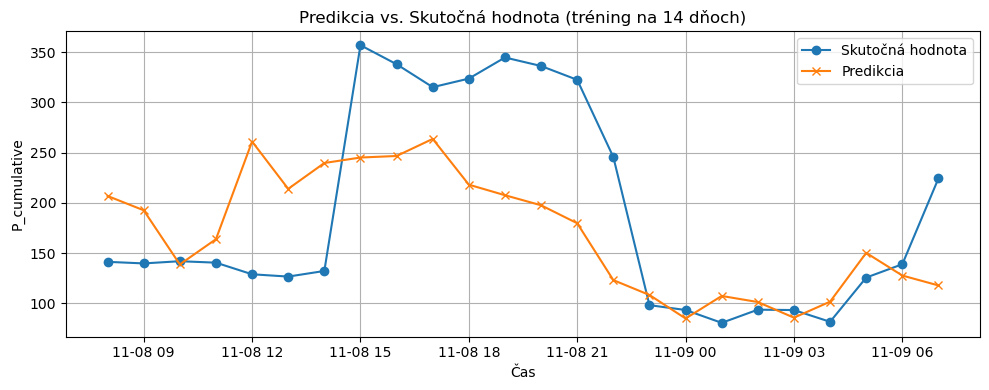

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error

# Zoradenie podľa času, poistka!!!
df2 = df2.sort_index()

# Nastavenie časových okien
train_days = 14
test_days = 1

# Tréning: 1. – 14. deň
start = df2.index[0]
train_end = start + pd.Timedelta(days=train_days)
test_end = train_end + pd.Timedelta(days=test_days)

train = df2.loc[(df2.index >= start) & (df2.index < train_end)]
test = df2.loc[(df2.index >= train_end) & (df2.index < test_end)]

# Tréning modelu pomocou auto_arima
model = auto_arima(train['P_cumulative'],
                   start_p=1, max_p=3,
                   start_q=1, max_q=3,
                   start_P=0, max_P=1,
                   start_Q=0, max_Q=1,
                   d=None, D=1,
                   seasonal=True,
                   m=24,  # denná sezónnosť (hodinové dáta)
                   stepwise=True,
                   n_jobs=1,
                   suppress_warnings=True,
                   error_action='ignore',
                   trace=True)

# Výpis nájdených parametrov
print("\n🔧 Najlepšie nájdené parametre:")
print(f"order = {model.order}")
print(f"seasonal_order = {model.seasonal_order}")

# Predikcia na 15. deň (24 hodín)
forecast = model.predict(n_periods=24)
true_values = test['P_cumulative'].values[:len(forecast)]
forecast = forecast[:len(true_values)]

# Výpočet MAPE
mape = mean_absolute_percentage_error(true_values, forecast)
print(f"\n MAPE (14 dní tréning, 15. deň predikcia): {mape * 100:.2f}%")

# Vizualizácia
plt.figure(figsize=(10, 4))
plt.plot(test.index, true_values, label='Skutočná hodnota', marker='o')
plt.plot(test.index, forecast, label='Predikcia', marker='x')
plt.title('Predikcia vs. Skutočná hodnota (tréning na 14 dňoch)')
plt.xlabel('Čas')
plt.ylabel('P_cumulative')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=5351.148, Time=0.83 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=5532.924, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=5267.758, Time=7.11 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=12.57 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=5531.223, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=5353.056, Time=0.41 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=7.91 sec
 ARIMA(1,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=5.81 sec
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=5447.497, Time=27.17 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=5265.181, Time=5.61 sec
 ARIMA(2,0,0)(0,1,0)[24] intercept   : AIC=5350.438, Time=0.65 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=11.35 sec
 ARIMA(2,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=9.48 sec
 ARIMA(3,0,0)(1,1,0)[24] intercept   : AIC=5266.356, Time=9.66 sec
 ARIMA(2,0,1)(1,1,0)[24] intercept   : AI

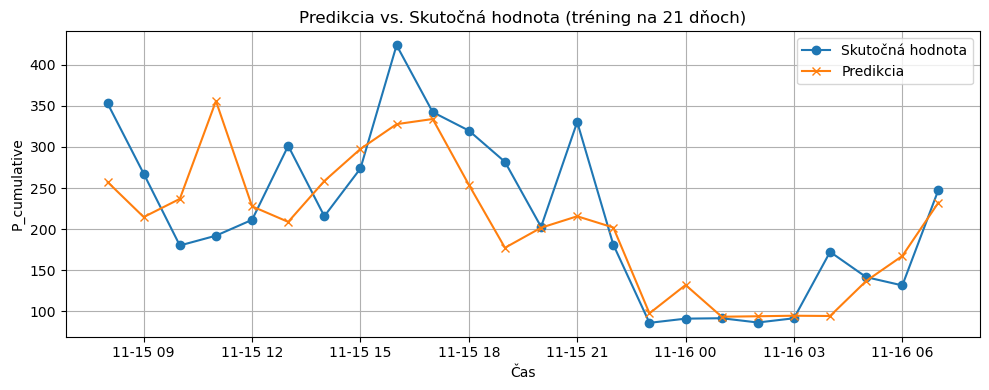

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error

# Zoradenie podľa času, poistka!!!
df2 = df2.sort_index()

# Nastavenie časových okien
train_days = 21
test_days = 1

# Tréning: 1. – 21. deň
start = df2.index[0]
train_end = start + pd.Timedelta(days=train_days)
test_end = train_end + pd.Timedelta(days=test_days)

train = df2.loc[(df2.index >= start) & (df2.index < train_end)]
test = df2.loc[(df2.index >= train_end) & (df2.index < test_end)]

# Tréning modelu pomocou auto_arima
model = auto_arima(train['P_cumulative'],
                   start_p=1, max_p=3,
                   start_q=1, max_q=3,
                   start_P=0, max_P=1,
                   start_Q=0, max_Q=1,
                   d=None, D=1,
                   seasonal=True,
                   m=24,  # denná sezónnosť pre hodinové dáta
                   stepwise=True,
                   n_jobs=1,
                   suppress_warnings=True,
                   error_action='ignore',
                   trace=True)

# Výpis nájdených parametrov
print("\n🔧 Najlepšie nájdené parametre:")
print(f"order = {model.order}")
print(f"seasonal_order = {model.seasonal_order}")

# Predikcia na 22. deň (24 hodín)
forecast = model.predict(n_periods=24)
true_values = test['P_cumulative'].values[:len(forecast)]
forecast = forecast[:len(true_values)]

# Výpočet MAPE
mape = mean_absolute_percentage_error(true_values, forecast)
print(f"\n MAPE (21 dní tréning, 22. deň predikcia): {mape * 100:.2f}%")

# Vizualizácia
plt.figure(figsize=(10, 4))
plt.plot(test.index, true_values, label='Skutočná hodnota', marker='o')
plt.plot(test.index, forecast, label='Predikcia', marker='x')
plt.title('Predikcia vs. Skutočná hodnota (tréning na 21 dňoch)')
plt.xlabel('Čas')
plt.ylabel('P_cumulative')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### SARIMA modelovanie pre rôzne časové intervaly

V rámci tejto časti sme realizovali predikciu činného výkonu pomocou modelu **SARIMA** pre rôzne dĺžky tréningových období, konkrétne **7, 14 a 21 dní**. Predikcia bola vždy vykonaná na **nasledujúci 1 deň** (24 hodín).

#### Postup:

- Pre každý časový interval prebiehalo modelovanie v niekoľkých po sebe idúcich iteráciách, kde sa tréningové a testovacie okná posúvali v čase.
- V každej iterácii bol model trénovaný na zodpovedajúcom intervale a predikoval hodnoty pre nasledujúci deň.
- Výsledky predikcie boli porovnané so skutočnými hodnotami pomocou metrík **MAPE** a **MAE**.
- Po všetkých iteráciách boli vypočítané priemerné, minimálne a maximálne hodnoty metrík




In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# Zoradenie dát podľa času a nastavenie frekvencie
df2 = df2.sort_index()
df2 = df2.asfreq('H')  # predpokladáme hodinové údaje

# Parametre
train_days = 14   # 2 týždne tréningu
test_days = 1     # 1 deň testovania
total_iterations = 14
mape_list = []
mae_list = []

for i in range(total_iterations):
    print(f"\nIterácia {i+1}/{total_iterations}")

    # Výpočet časových okien
    start_i = df2.index[0] + pd.Timedelta(days=i)
    train_end_i = start_i + pd.Timedelta(days=train_days)
    test_end_i = train_end_i + pd.Timedelta(days=test_days)

    # Tréningové a testovacie dáta
    train_i = df2.loc[(df2.index >= start_i) & (df2.index < train_end_i)]
    test_i = df2.loc[(df2.index >= train_end_i) & (df2.index < test_end_i)]

    # Tréning modelu
    model_i = SARIMAX(train_i['P_cumulative'],
                      order=(1, 0, 0),
                      seasonal_order=(1, 1, 0, 24),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
    
    results_i = model_i.fit(disp=False)

    # Predikcia na 24 hodín
    forecast_i = results_i.forecast(steps=24)

    # Skutočné hodnoty
    true_values_i = test_i['P_cumulative'].values[:len(forecast_i)]
    forecast_i = forecast_i[:len(true_values_i)]

    # Výpočet metrík
    mape_i = mean_absolute_percentage_error(true_values_i, forecast_i)
    mae_i = mean_absolute_error(true_values_i, forecast_i)

    mape_list.append(mape_i)
    mae_list.append(mae_i)

    print(f"MAPE iterácie {i+1}: {mape_i * 100:.2f}%")
    print(f"MAE iterácie {i+1}: {mae_i:.2f}")

    # V prípade potreby odkomentovať pre vizualizáciu!!!!
    # plt.figure(figsize=(8, 4))
    # plt.plot(test_i.index[:len(true_values_i)], true_values_i, label='Skutočná hodnota', marker='o')
    # plt.plot(test_i.index[:len(forecast_i)], forecast_i, label='Predikcia', marker='x')
    # plt.title(f'Predikcia vs. Skutočná hodnota (iterácia {i+1})')
    # plt.xlabel('Čas')
    # plt.ylabel('P_cumulative')
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

# Výsledky po všetkých iteráciách
average_mape = sum(mape_list) / len(mape_list)
min_mape = min(mape_list)
max_mape = max(mape_list)

average_mae = sum(mae_list) / len(mae_list)
min_mae = min(mae_list)
max_mae = max(mae_list)

#vyhodnotenie
print("\nVýsledky po 14 iteráciách:")
print(f"Priemerné MAPE: {average_mape * 100:.2f}%")
print(f"Minimálne MAPE: {min_mape * 100:.2f}%")
print(f"Maximálne MAPE: {max_mape * 100:.2f}%")
print(f"Priemerné MAE: {average_mae:.2f}")
print(f"Minimálne MAE: {min_mae:.2f}")
print(f"Maximálne MAE: {max_mae:.2f}")


C:\Users\patri\AppData\Local\Temp\ipykernel_87064\636657831.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df2 = df2.asfreq('H')  # predpokladáme hodinové údaje



Iterácia 1/14
MAPE iterácie 1: 33.79%
MAE iterácie 1: 66.83

Iterácia 2/14
MAPE iterácie 2: 21.15%
MAE iterácie 2: 39.92

Iterácia 3/14
MAPE iterácie 3: 12.60%
MAE iterácie 3: 19.94

Iterácia 4/14
MAPE iterácie 4: 11.78%
MAE iterácie 4: 22.45

Iterácia 5/14
MAPE iterácie 5: 25.01%
MAE iterácie 5: 55.66

Iterácia 6/14
MAPE iterácie 6: 18.42%
MAE iterácie 6: 38.95

Iterácia 7/14
MAPE iterácie 7: 23.02%
MAE iterácie 7: 49.17

Iterácia 8/14
MAPE iterácie 8: 20.81%
MAE iterácie 8: 47.63

Iterácia 9/14
MAPE iterácie 9: 20.59%
MAE iterácie 9: 48.73

Iterácia 10/14
MAPE iterácie 10: 19.44%
MAE iterácie 10: 36.37

Iterácia 11/14
MAPE iterácie 11: 43.65%
MAE iterácie 11: 59.56

Iterácia 12/14
MAPE iterácie 12: 13.92%
MAE iterácie 12: 26.84

Iterácia 13/14
MAPE iterácie 13: 14.55%
MAE iterácie 13: 28.46

Iterácia 14/14
MAPE iterácie 14: 12.34%
MAE iterácie 14: 25.79

Výsledky po 14 iteráciách:
Priemerné MAPE: 20.79%
Minimálne MAPE: 11.78%
Maximálne MAPE: 43.65%
Priemerné MAE: 40.45
Minimálne MAE

C:\Users\patri\AppData\Local\Temp\ipykernel_87064\4275350830.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df2 = df2.asfreq('H')  # predpokladáme hodinové dáta



Iterácia 1/7
MAPE iterácie 1: 20.92%
MAE iterácie 1: 48.02


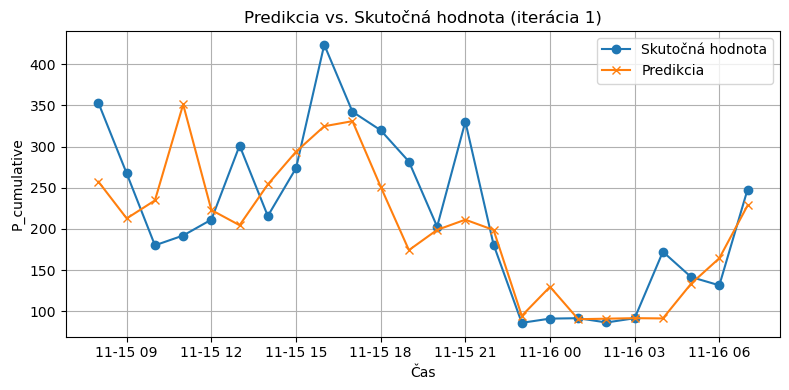


Iterácia 2/7
MAPE iterácie 2: 19.68%
MAE iterácie 2: 46.67


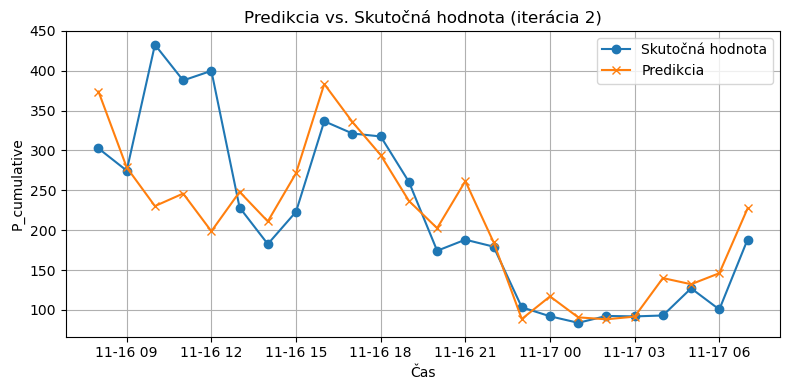


Iterácia 3/7
MAPE iterácie 3: 20.02%
MAE iterácie 3: 37.23


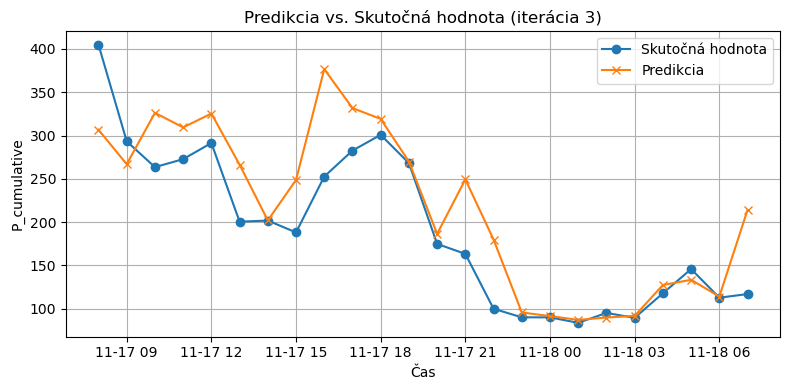


Iterácia 4/7
MAPE iterácie 4: 43.72%
MAE iterácie 4: 58.92


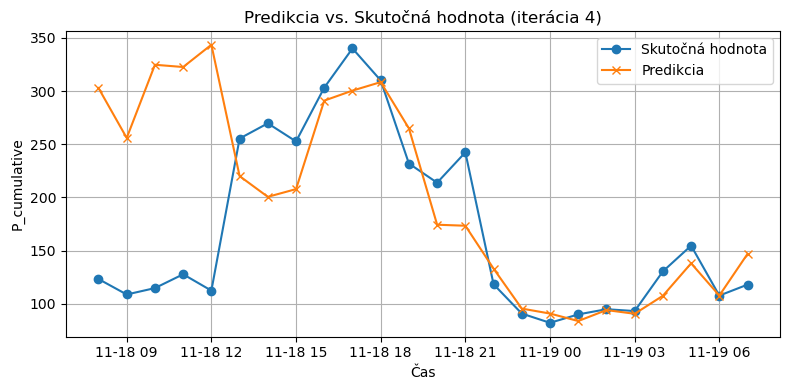


Iterácia 5/7
MAPE iterácie 5: 16.90%
MAE iterácie 5: 30.43


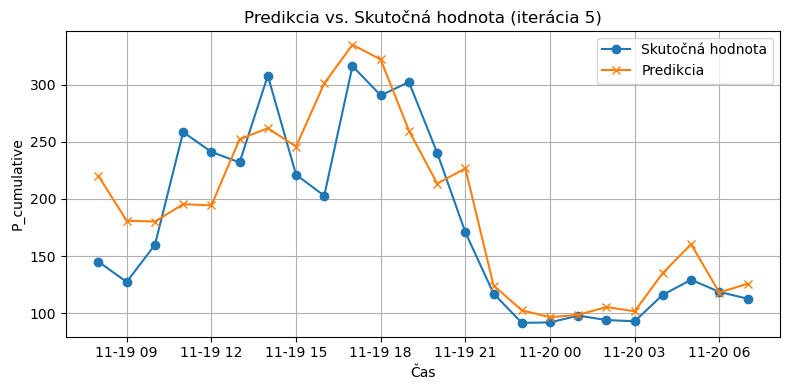


Iterácia 6/7
MAPE iterácie 6: 14.14%
MAE iterácie 6: 27.63


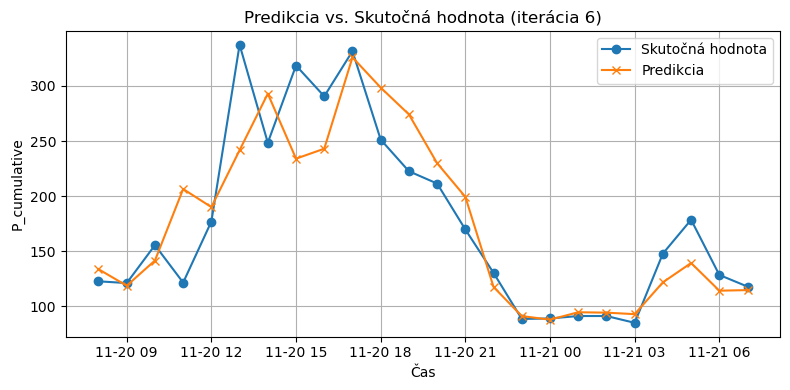


Iterácia 7/7
MAPE iterácie 7: 11.84%
MAE iterácie 7: 24.66


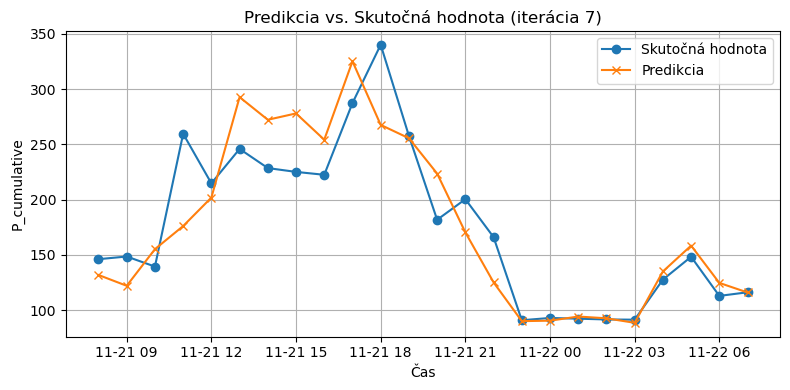


Výsledky po 7 iteráciách:
Priemerné MAPE: 21.03%
Minimálne MAPE: 11.84%
Maximálne MAPE: 43.72%
Priemerné MAE: 39.08
Minimálne MAE: 24.66
Maximálne MAE: 58.92


In [70]:
#knižnice
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

#Zoradenie dát podľa časovej osi a nastavenie hodinovej frekvencie, poistka
df2 = df2.sort_index()
df2 = df2.asfreq('H')  # predpokladáme hodinové dáta

#Parametre pre časové okná
train_days = 21          # dĺžka tréningu v dňoch
test_days = 1            # dĺžka testovania (1 deň)
total_iterations = 7     # počet časových posunov

#Zoznamy pre ukladanie metrík
mape_list = []
mae_list = []

#Iteračný cyklus cez časové okná
for i in range(total_iterations):
    print(f"\nIterácia {i+1}/{total_iterations}")

    #Výpočet začiatku a konca tréningového/testovacieho intervalu
    start_i = df2.index[0] + pd.Timedelta(days=i)
    train_end_i = start_i + pd.Timedelta(days=train_days)
    test_end_i = train_end_i + pd.Timedelta(days=test_days)

    #Výber tréningových a testovacích dát
    train_i = df2.loc[(df2.index >= start_i) & (df2.index < train_end_i)]
    test_i = df2.loc[(df2.index >= train_end_i) & (df2.index < test_end_i)]

    #Tréning SARIMAX modelu
    model_i = SARIMAX(train_i['P_cumulative'],
                      order=(2, 0, 1),
                      seasonal_order=(1, 1, 0, 24),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
    
    results_i = model_i.fit(disp=False)

    #Predikcia na 24 hodín
    forecast_i = results_i.forecast(steps=24)

    #skutočné hodnoty z testovacieho dňa
    true_values_i = test_i['P_cumulative'].values[:len(forecast_i)]
    forecast_i = forecast_i[:len(true_values_i)]

    #Výpočet metrík MAPE a MAE
    mape_i = mean_absolute_percentage_error(true_values_i, forecast_i)
    mae_i = mean_absolute_error(true_values_i, forecast_i)

    #Uloženie metrík
    mape_list.append(mape_i)
    mae_list.append(mae_i)

    print(f"MAPE iterácie {i+1}: {mape_i * 100:.2f}%")
    print(f"MAE iterácie {i+1}: {mae_i:.2f}")

    #Zobrazenie grafu – predikcia vs. skutočnosť
    plt.figure(figsize=(8, 4))
    plt.plot(test_i.index[:len(true_values_i)], true_values_i, label='Skutočná hodnota', marker='o')
    plt.plot(test_i.index[:len(forecast_i)], forecast_i, label='Predikcia', marker='x')
    plt.title(f'Predikcia vs. Skutočná hodnota (iterácia {i+1})')
    plt.xlabel('Čas')
    plt.ylabel('P_cumulative')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Výpočet a výpis celkových výsledkov
average_mape = sum(mape_list) / len(mape_list)
min_mape = min(mape_list)
max_mape = max(mape_list)

average_mae = sum(mae_list) / len(mae_list)
min_mae = min(mae_list)
max_mae = max(mae_list)

#vyhodnotenie
print("\nVýsledky po 7 iteráciách:")
print(f"Priemerné MAPE: {average_mape * 100:.2f}%")
print(f"Minimálne MAPE: {min_mape * 100:.2f}%")
print(f"Maximálne MAPE: {max_mape * 100:.2f}%")
print(f"Priemerné MAE: {average_mae:.2f}")
print(f"Minimálne MAE: {min_mae:.2f}")
print(f"Maximálne MAE: {max_mae:.2f}")


C:\Users\patri\AppData\Local\Temp\ipykernel_87064\1424652222.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df2 = df2.asfreq('H')  # predpokladáme hodinové dáta



Iterácia 1/21
MAPE iterácie 1: 20.74%
MAE iterácie 1: 34.85


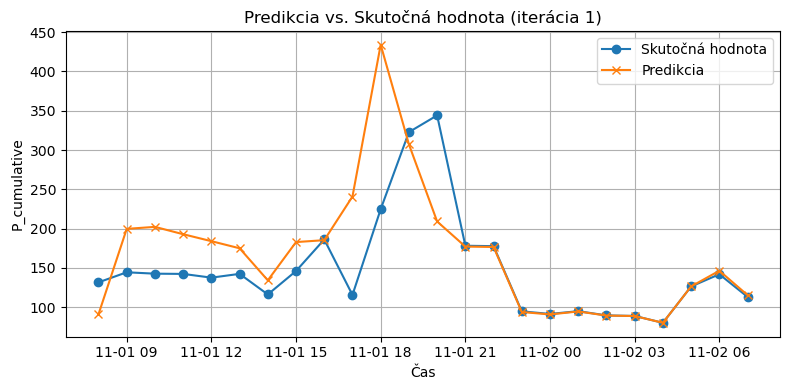


Iterácia 2/21
MAPE iterácie 2: 21.88%
MAE iterácie 2: 58.92


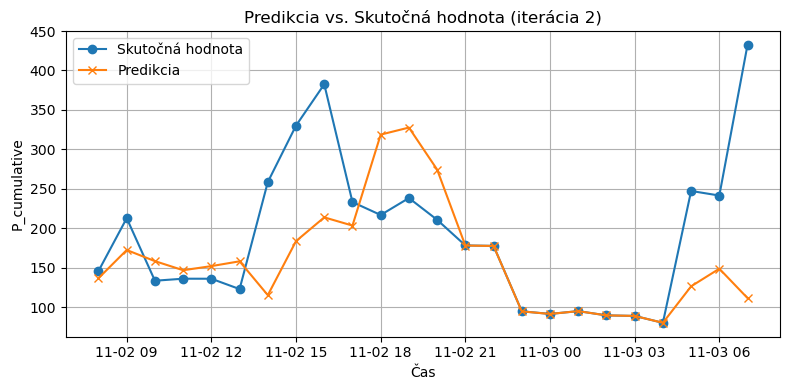


Iterácia 3/21
MAPE iterácie 3: 33.19%
MAE iterácie 3: 61.77


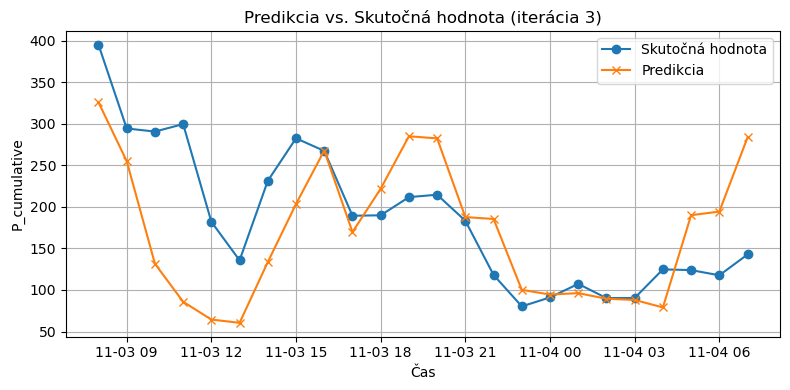


Iterácia 4/21
MAPE iterácie 4: 25.40%
MAE iterácie 4: 36.16


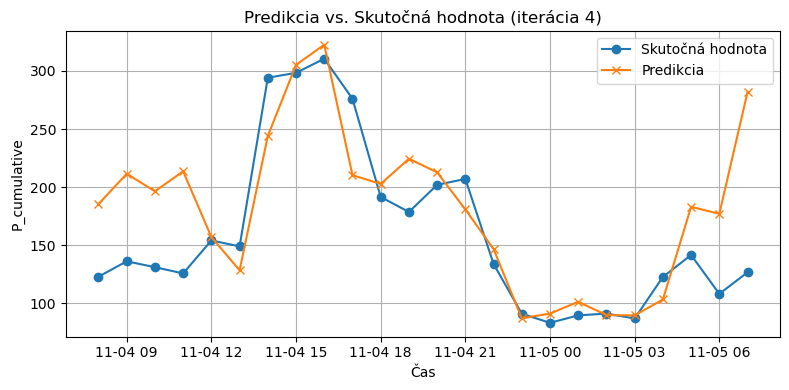


Iterácia 5/21
MAPE iterácie 5: 17.27%
MAE iterácie 5: 36.23


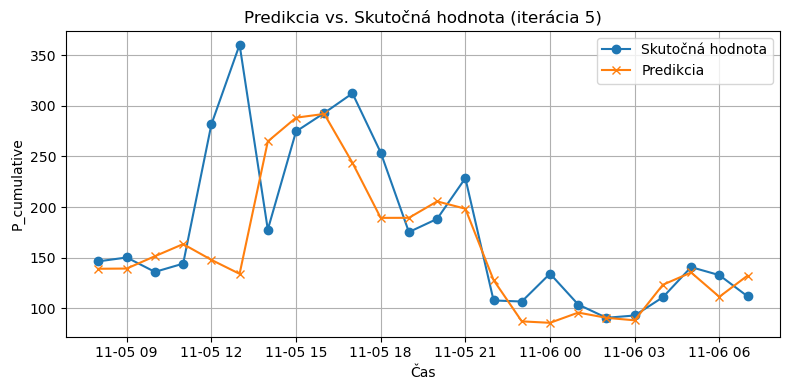


Iterácia 6/21
MAPE iterácie 6: 9.57%
MAE iterácie 6: 15.06


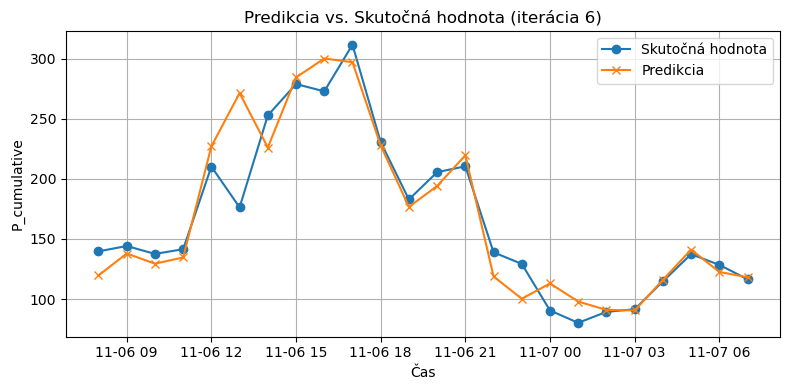


Iterácia 7/21
MAPE iterácie 7: 21.33%
MAE iterácie 7: 37.69


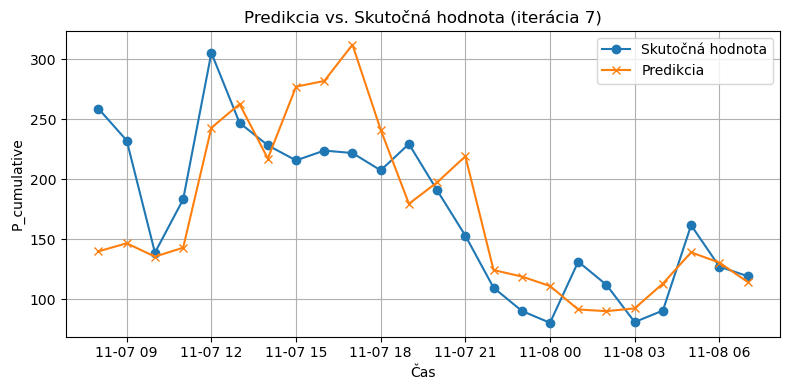


Iterácia 8/21
MAPE iterácie 8: 33.55%
MAE iterácie 8: 66.39


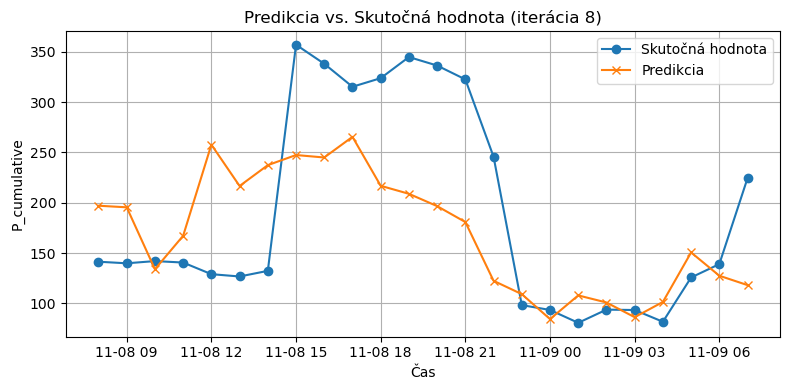


Iterácia 9/21
MAPE iterácie 9: 18.38%
MAE iterácie 9: 35.39


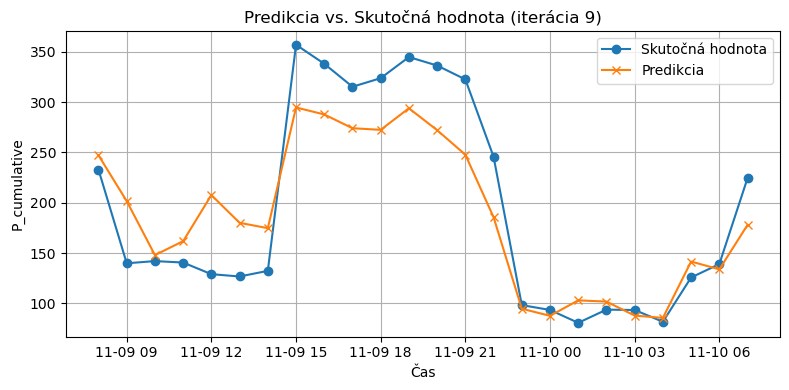


Iterácia 10/21
MAPE iterácie 10: 12.56%
MAE iterácie 10: 19.92


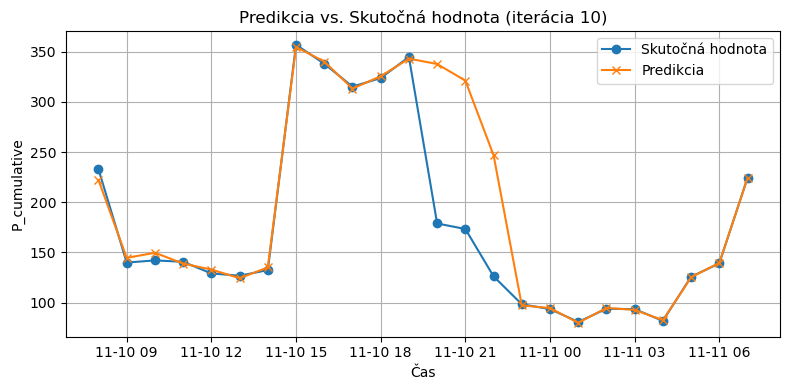


Iterácia 11/21
MAPE iterácie 11: 13.64%
MAE iterácie 11: 25.28


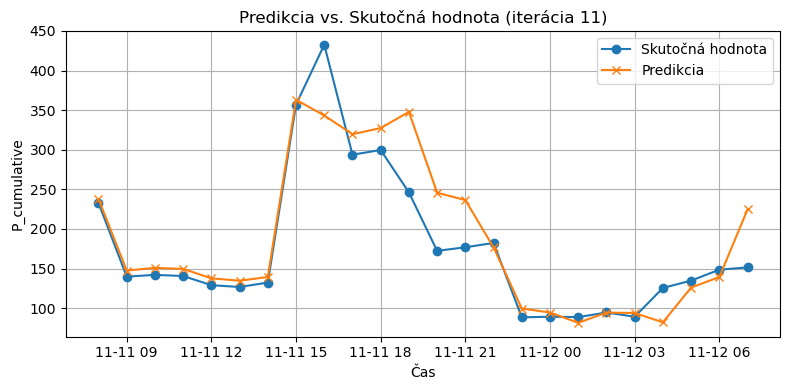


Iterácia 12/21
MAPE iterácie 12: 24.60%
MAE iterácie 12: 55.02


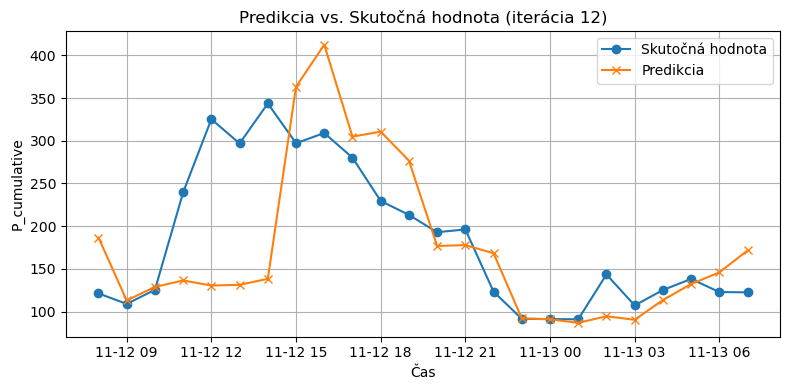


Iterácia 13/21
MAPE iterácie 13: 17.18%
MAE iterácie 13: 35.23


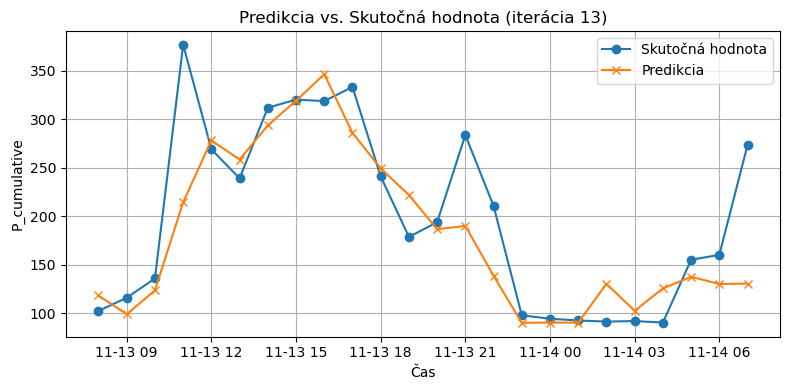


Iterácia 14/21
MAPE iterácie 14: 21.06%
MAE iterácie 14: 47.36


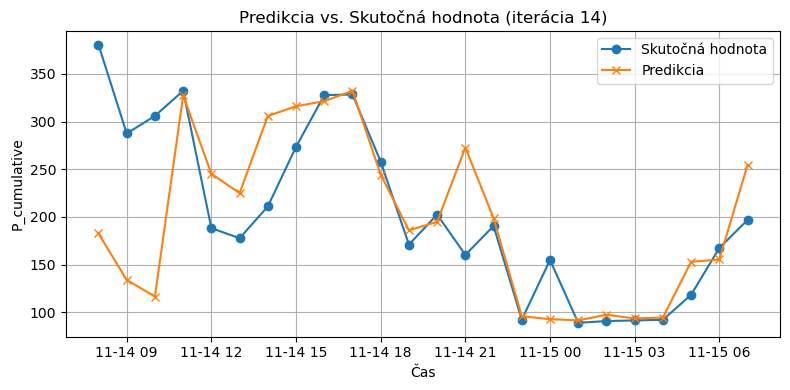


Iterácia 15/21
MAPE iterácie 15: 21.42%
MAE iterácie 15: 48.32


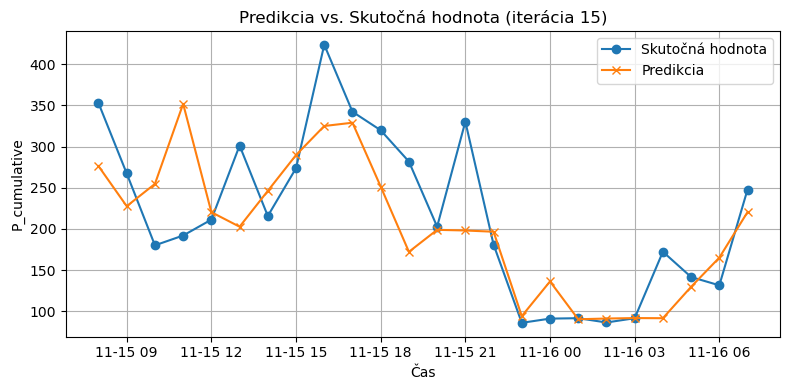


Iterácia 16/21
MAPE iterácie 16: 20.51%
MAE iterácie 16: 48.94


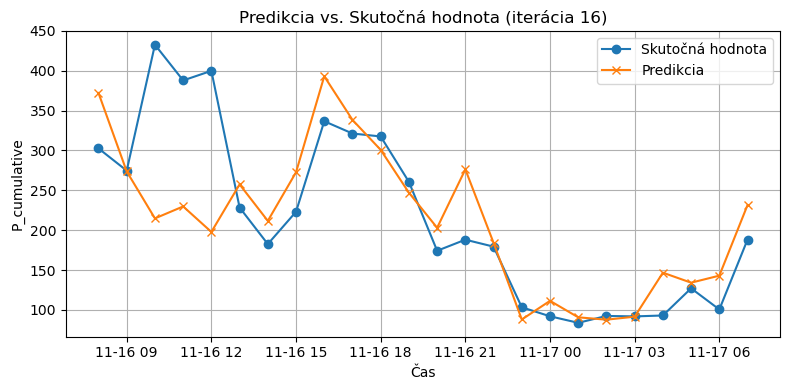


Iterácia 17/21
MAPE iterácie 17: 20.00%
MAE iterácie 17: 36.94


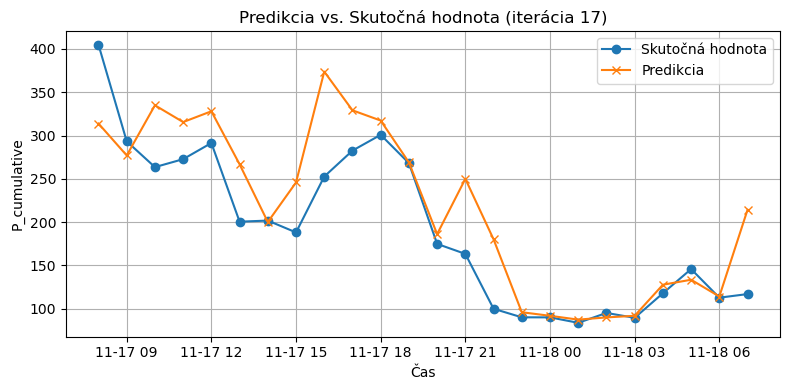


Iterácia 18/21
MAPE iterácie 18: 47.29%
MAE iterácie 18: 61.50


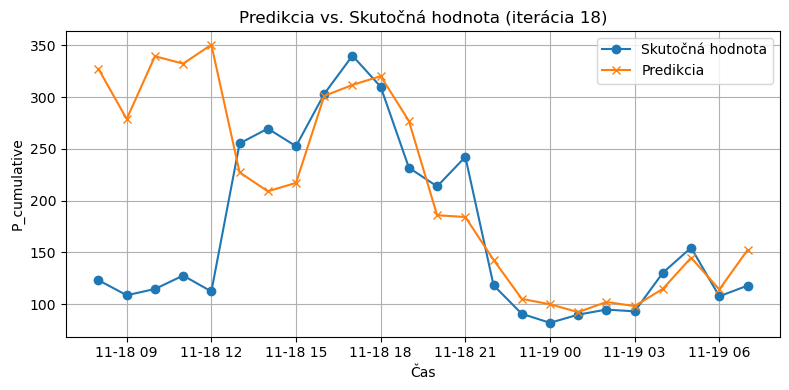


Iterácia 19/21
MAPE iterácie 19: 14.36%
MAE iterácie 19: 26.77


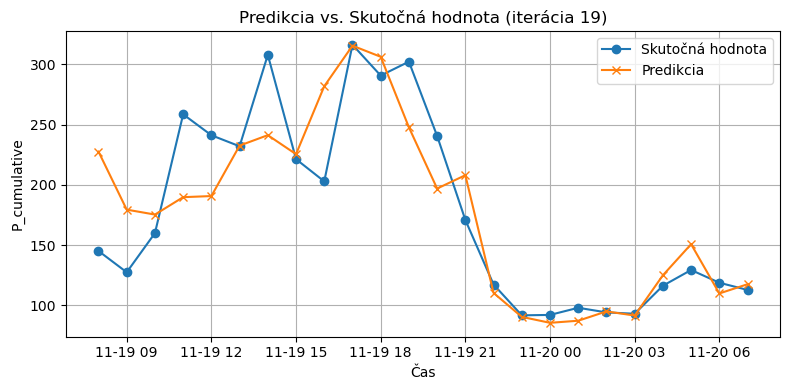


Iterácia 20/21


C:\Users\patri\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE iterácie 20: 13.48%
MAE iterácie 20: 26.33


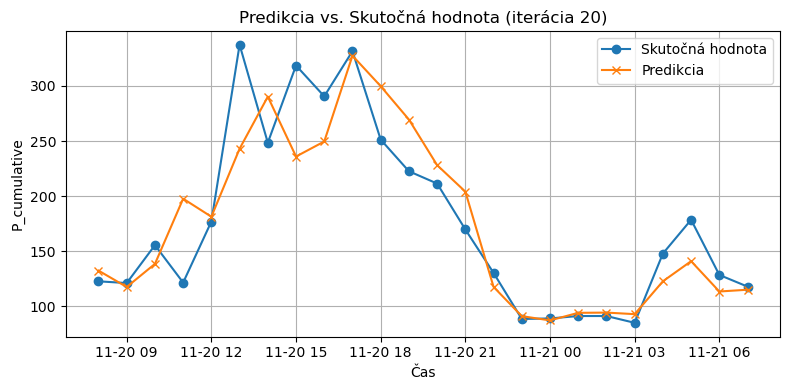


Iterácia 21/21
MAPE iterácie 21: 10.96%
MAE iterácie 21: 22.76


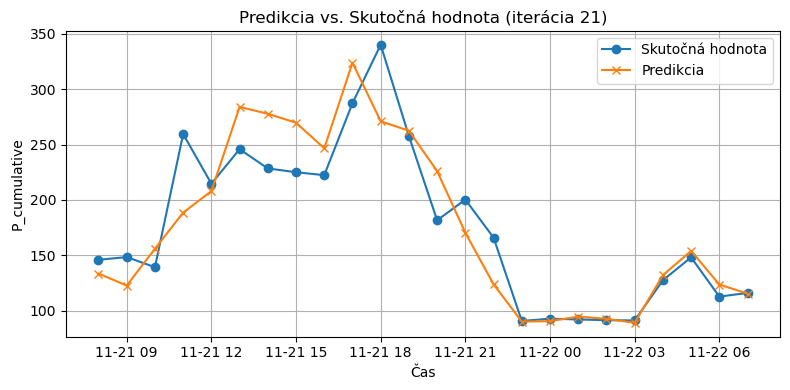


Výsledky po 21 iteráciách:
Priemerné MAPE: 20.87%
Minimálne MAPE: 9.57%
Maksimálne MAPE: 47.29%
Priemerné MAE: 39.85
Minimálne MAE: 15.06
Maximálne MAE: 66.39


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# Zoradenie dát podľa časovej osi a nastavenie hodinovej frekvencie, poistka
df2 = df2.sort_index()
df2 = df2.asfreq('H')  # predpokladáme hodinové dáta

# Parametre pre časové okná
train_days = 7          # dĺžka tréningu v dňoch
test_days = 1           # dĺžka testovania (1 deň)
total_iterations = 21   # počet posunov v čase

# Zoznamy pre ukladanie metrík
mape_list = []
mae_list = []

# Iteračný cyklus cez rôzne časové posuny
for i in range(total_iterations):
    print(f"\nIterácia {i+1}/{total_iterations}")

    # Výpočet začiatku a konca tréningového/testovacieho intervalu
    start_i = df2.index[0] + pd.Timedelta(days=i)
    train_end_i = start_i + pd.Timedelta(days=train_days)
    test_end_i = train_end_i + pd.Timedelta(days=test_days)

    # Výber tréningových a testovacích dát
    train_i = df2.loc[(df2.index >= start_i) & (df2.index < train_end_i)]
    test_i = df2.loc[(df2.index >= train_end_i) & (df2.index < test_end_i)]

    # Tréning SARIMAX modelu s určeným nastavením parametrov
    model_i = SARIMAX(train_i['P_cumulative'],
                      order=(2, 0, 1),
                      seasonal_order=(1, 1, 0, 24),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
    
    results_i = model_i.fit(disp=False)

    # Predikcia na nasledujúcich 24 hodín (1 deň)
    forecast_i = results_i.forecast(steps=24)

    # Skutočné hodnoty z testovacieho dňa
    true_values_i = test_i['P_cumulative'].values[:len(forecast_i)]
    forecast_i = forecast_i[:len(true_values_i)]

    # Výpočet metrík MAPE a MAE
    mape_i = mean_absolute_percentage_error(true_values_i, forecast_i)
    mae_i = mean_absolute_error(true_values_i, forecast_i)

    # Uloženie metrík
    mape_list.append(mape_i)
    mae_list.append(mae_i)

    print(f"MAPE iterácie {i+1}: {mape_i * 100:.2f}%")
    print(f"MAE iterácie {i+1}: {mae_i:.2f}")

    # Zobrazenie grafu – predikcia vs. skutočnosť
    plt.figure(figsize=(8, 4))
    plt.plot(test_i.index[:len(true_values_i)], true_values_i, label='Skutočná hodnota', marker='o')
    plt.plot(test_i.index[:len(forecast_i)], forecast_i, label='Predikcia', marker='x')
    plt.title(f'Predikcia vs. Skutočná hodnota (iterácia {i+1})')
    plt.xlabel('Čas')
    plt.ylabel('P_cumulative')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Výpočet a výpis celkových výsledkov
average_mape = sum(mape_list) / len(mape_list)
min_mape = min(mape_list)
max_mape = max(mape_list)

average_mae = sum(mae_list) / len(mae_list)
min_mae = min(mae_list)
max_mae = max(mae_list)

#vyhodnotenie
print("\nVýsledky po 21 iteráciách:")
print(f"Priemerné MAPE: {average_mape * 100:.2f}%")
print(f"Minimálne MAPE: {min_mape * 100:.2f}%")
print(f"Maksimálne MAPE: {max_mape * 100:.2f}%")
print(f"Priemerné MAE: {average_mae:.2f}")
print(f"Minimálne MAE: {min_mae:.2f}")
print(f"Maximálne MAE: {max_mae:.2f}")
